### Import des modules necéssaires au projet

In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import re
import math
import seaborn as sns 
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
import time
from sklearn.tree import DecisionTreeRegressor
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
import warnings
warnings.filterwarnings("ignore")

### Requête SQL pour la dernière date de commande 

**Résultat :** *2018-10-17 17:30:18*

## Explications

Nous souhaitons voir si nos modèles de segmentation (la liste 2 de variables a été retenue) sont susceptibles de ne plus être pertinentes, avec le temps qui avance.


Pour vérifier celà, nous allons séparer notre jeu de données par différentes intervalles de temps et faire des tests de segmentation sur chaque split résultant , avec le même choix de variables tout du long bien sûr. Le but est de voir si nos classes/clusters restent les mêmes malgré la temporalité prise en compte.
De plus, il sera préférable pour ceci de ne pas prendre des temporalités trop petites afin que la distribution du jeu de données initial soit relativement respectée.



Pour faire cela, au lieu de faire un grand nombre de requêtes SQL différentes pour les différentes temporalités, nous allons réutiliser notre jeu de données qui nous a permis en premier temps de faire notre modélisation. Pour cela, nous aurons besoin des valeurs de la variable *days_since_last_order* et de la date de la dernière commande afin d'avoir les dates de chaque commande  et de pouvoir découper le jeu de données dans la temporalité que nous souhaitons.

Evidemment, selon les temporalités, nous aurons besoin de mettre à jour chaque split de jeu données pour les valeurs days_since_last_order.

#### Chargement du jeu de données du précédent notebook de modélisation

In [2]:
import pandas as pd

# Définir le chemin du fichier CSV
file_path = r"C:\Users\pdevi\OneDrive\Desktop\OpenClassrooms\Projet_3\DATA_LAST\data_cleaned.csv"

# Lire le fichier CSV dans un DataFrame
data_retrieved = pd.read_csv(file_path)

# Afficher les premières lignes du DataFrame pour vérifier
print(data_retrieved.head())


                 customer_unique_id  days_since_last_order  average_days_diff  \
0  ffffd2657e2aad2907e67c3e9daecbeb             532.883021         532.883021   
1  ffff5962728ec6157033ef9805bacc48             168.092095         168.092095   
2  ffff371b4d645b6ecea244b27531430a             617.070162         617.070162   
3  fffea47cd6d3cc0a88bd621562a9d061             310.890532         310.890532   
4  fffcf5a5ff07b0908bd4e2dbc735a684             495.853958         495.853958   

   std_dev_days_diff  mean_order_reviews_score_of_given_client  \
0                0.0                                       5.0   
1                0.0                                       5.0   
2                0.0                                       5.0   
3                0.0                                       4.0   
4                0.0                                       5.0   

   average_order_price_of_client  non_cancelled_orders_count  \
0                          56.99                    

## Fonctionnement du Code

1. **Importation** : Importation des bibliothèques nécessaires (`pandas`, `datetime`, `sklearn`, `matplotlib`).
2. **Division Temporelle** : La fonction `diviser_donnees_par_temporalite` segmente les données en intervalles de temps définis, ajustant les jours depuis la dernière commande pour chaque segment.
3. **Calcul de l'ARI** : La fonction `calculer_ari` évalue les clusters sur chaque segment temporel, calculant l'indice de Rand ajusté (ARI) pour détecter la nécessité de réentraîner le modèle.
4. **Entraînement du Modèle** : La fonction `entrainer_modele` normalise les données et entraîne un modèle KMeans initial.
5. **Visualisation** : La fonction `plot_ari` affiche l'évolution des scores ARI pour les segments temporels.

## Pertinence pour la Réévaluation de la Segmentation Client

1. **Segmentation Dynamique** : Permet l'analyse de la segmentation client sur différentes périodes, détectant les changements de comportement.
2. **Détection de Dégradation** : Utilise l'ARI pour identifier quand le modèle doit être réentraîné, assurant des performances constantes.
3. **Flexibilité Temporelle** : Adaptable à différentes granularités temporelles, permettant une analyse fine et ajustée.
4. **Visualisation Claire** : Aide à la prise de décision grâce à des visualisations des scores ARI et des seuils de réentraînement.
5. **Amélioration Continue** : Maintient la pertinence de la segmentation en s'adaptant aux nouvelles tendances clients.

Ce code facilite une réévaluation régulière et dynamique de la segmentation client, garantissant que le modèle reste pertinent et performant.


In [3]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt

def diviser_donnees_par_temporalite(data_retrieved, date_derniere_commande, date_debut, temporalite_jours):
    datetime_derniere_commande = datetime.strptime(date_derniere_commande, '%Y-%m-%d')
    datetime_debut = datetime.strptime(date_debut, '%Y-%m-%d')
    nombre_splits = (datetime_derniere_commande - datetime_debut).days // temporalite_jours
    data_retrieved['order_date'] = datetime_derniere_commande - pd.to_timedelta(data_retrieved['days_since_last_order'], unit='D')
    dataframes_divises = []
    for i in range(nombre_splits + 1):
        date_debut_split = datetime_debut + timedelta(days=i * temporalite_jours)
        date_fin_split = date_debut_split + timedelta(days=temporalite_jours)
        split_df = data_retrieved[(data_retrieved['order_date'] >= date_debut_split) & (data_retrieved['order_date'] < date_fin_split)].copy()
        if not split_df.empty:
            date_commande_plus_recente = split_df['order_date'].max()
            split_df['days_since_last_order'] = (date_commande_plus_recente - split_df['order_date']).dt.days
            split_df['days_since_last_order'] = split_df['days_since_last_order'] - split_df['days_since_last_order'].min()
        split_df.drop(columns=['order_date'], inplace=True)
        dataframes_divises.append(split_df)
    return dataframes_divises

def calculer_ari(data_retrieved, date_derniere_commande, date_debut, temporalite_jours, initial_scaler, initial_model, seuil_ari=0.8):
    dfs_divises = diviser_donnees_par_temporalite(data_retrieved, date_derniere_commande, date_debut, temporalite_jours)
    initial_labels = initial_model.labels_
    initial_data = data_retrieved[selected_columns]
    scaled_initial_data = pd.DataFrame(initial_scaler.transform(initial_data), columns=selected_columns)
    ari_scores = []
    for split_index, split_df in enumerate(dfs_divises):
        if not split_df.empty:
            split_selected_df = split_df[selected_columns].copy()
            scaled_split_selected_df = pd.DataFrame(initial_scaler.transform(split_selected_df), columns=selected_columns)
            split_clusters = initial_model.predict(scaled_split_selected_df)
            initial_labels_split = initial_labels[split_df.index]
            ari = adjusted_rand_score(initial_labels_split, split_clusters)
            ari_scores.append(ari)
            if ari < seuil_ari:
                date_fin_split = datetime.strptime(date_debut, '%Y-%m-%d') + timedelta(days=(split_index + 1) * temporalite_jours)
                print(f"Réentraînement nécessaire pour le split se terminant le {date_fin_split.date()}")
    return ari_scores

def plot_ari(ari_scores):
    plt.plot(range(1, len(ari_scores) + 1), ari_scores, marker='o')
    plt.xlabel('Split')
    plt.ylabel('ARI')
    plt.title('Évolution des scores ARI')
    plt.axhline(y=0.8, color='r', linestyle='--')
    plt.show()

On commmence d'avord avec la deuxième liste de variables (se référer au notebook précédent) avec un nombre de clusters à 5.

Réentraînement nécessaire pour le split se terminant le 2017-10-28
Réentraînement nécessaire pour le split se terminant le 2017-11-27
Réentraînement nécessaire pour le split se terminant le 2017-12-27
Réentraînement nécessaire pour le split se terminant le 2018-01-26
Réentraînement nécessaire pour le split se terminant le 2018-02-25
Réentraînement nécessaire pour le split se terminant le 2018-03-27


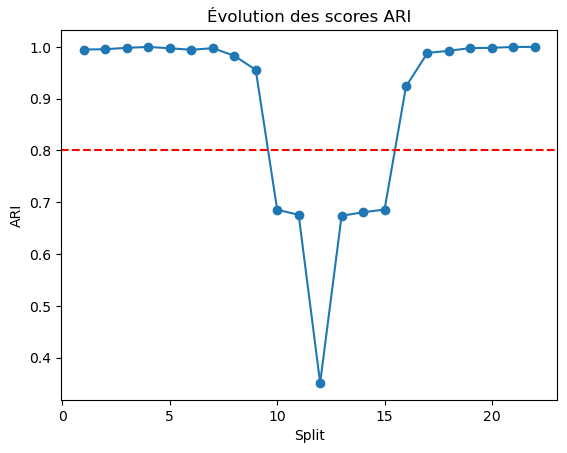

In [5]:
def entrainer_modele(data, selected_columns):
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data[selected_columns]), columns=selected_columns)
    kmeans = KMeans(n_clusters=5, random_state=42)
    kmeans.fit(scaled_data)
    return scaler, kmeans

# Préparation des données initiales
selected_columns = ['mean_order_reviews_score_of_given_client', 'average_order_price_of_client',
                    'non_cancelled_orders_count', 'days_since_last_order']

# Entraînement initial du modèle
initial_scaler, initial_model = entrainer_modele(data_retrieved, selected_columns)

# Simulation des périodes et calcul des scores ARI
date_derniere_commande = '2018-10-17'
date_debut = '2017-01-01'

temporalite_jours = 30

ari_scores = calculer_ari(data_retrieved, date_derniere_commande, date_debut, temporalite_jours, initial_scaler, initial_model)

# Affichage des scores ARI
plot_ari(ari_scores)


D'après le graphique, pour ce choix de variables, il faut donc réentraîner lorsque l'ARI passe en dessous de la limite à 0.8.
Donc on descend à partir du 9ème split, donc ici 9x30 = 270 jours. 

On passe ici à la première liste de variables (segmentation RFM) à 4 clusters ci-dessous pour voir le délai nécessaire pour réentrainer notre modèle. ON choisira la même temporalité pour les splits pour bien comparer.

Réentraînement nécessaire pour le split se terminant le 2017-12-27


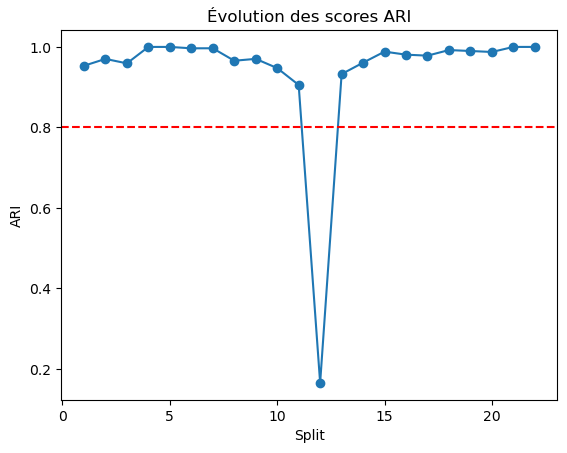

In [19]:

def entrainer_modele(data, selected_columns):
    scaler = StandardScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data[selected_columns]), columns=selected_columns)
    kmeans = KMeans(n_clusters=4, random_state=42)
    kmeans.fit(scaled_data)
    return scaler, kmeans
 
selected_columns = ['total_order_price_of_client', 'days_since_last_order', 'non_cancelled_orders_count']

# Entraînement initial du modèle
initial_scaler, initial_model = entrainer_modele(data_retrieved, selected_columns)

# Simulation des périodes et calcul des scores ARI
date_derniere_commande = '2018-10-17'
date_debut = '2017-01-01'
temporalite_jours = 30

ari_scores = calculer_ari(data_retrieved, date_derniere_commande, date_debut, temporalite_jours, initial_scaler, initial_model)

# Affichage des scores ARI
plot_ari(ari_scores)


On voit que la segmentation échoue à partir du 11ème split et que globalement ce modèle de segmentation est bien plus stable que notre précédente segmentation (deuxième liste de variables).
Ici, 11x30 = 320 jours soit quasiment une année entière pour laquelle le modèle de segmentation doit être réentrainé.

Nous garderons donc la liste initiale de variables (segmentation RFM) pour notre choix de modèle de part sa simplicité marketing mais également en termne de stabilité de modèle de segmentation.